##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
!pip install -q tf-nightly

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 1s

 5595136/68606236 [=>............................] - ETA: 0s

 8396800/68606236 [==>...........................] - ETA: 1s

22061056/68606236 [========>.....................] - ETA: 0s

33562624/68606236 [=============>................] - ETA: 0s

41951232/68606236 [=================>............] - ETA: 0s

55672832/68606236 [=======================>......] - ETA: 0s

63913984/68606236 [==========================>...] - ETA: 0s

68608000/68606236 [==============================] - 1s 0us/step


Found 2000 files belonging to 2 classes.


In [6]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

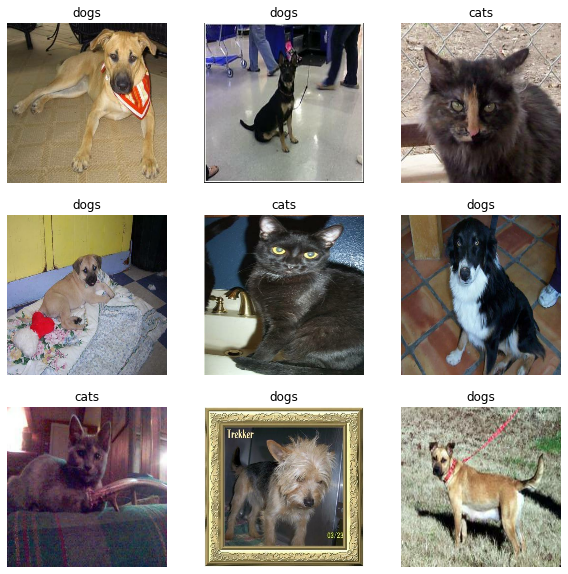

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

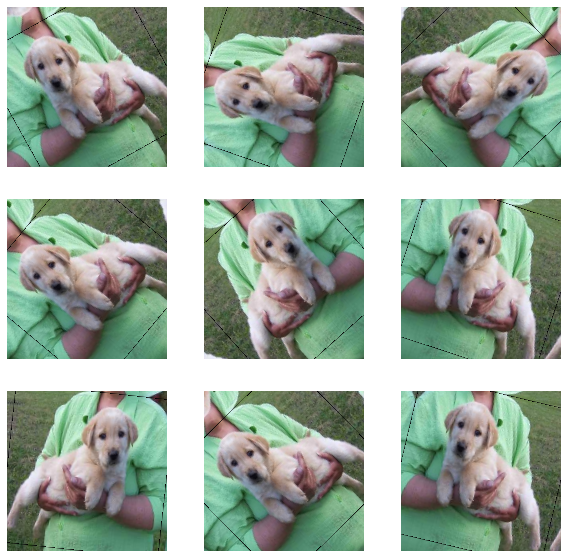

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

4202496/9406464 [============>.................] - ETA: 0s

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [17]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [24]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 46s - loss: 0.5920 - accuracy: 0.7188

 3/26 [==>...........................] - ETA: 14s - loss: 0.6331 - accuracy: 0.6476

 5/26 [====>.........................] - ETA: 8s - loss: 0.6453 - accuracy: 0.6314 

 7/26 [=======>......................] - ETA: 5s - loss: 0.6655 - accuracy: 0.6118

 9/26 [=========>....................] - ETA: 4s - loss: 0.6756 - accuracy: 0.6010

11/26 [===========>..................] - ETA: 3s - loss: 0.6846 - accuracy: 0.5932

13/26 [==============>...............] - ETA: 2s - loss: 0.6898 - accuracy: 0.5893

15/26 [================>.............] - ETA: 1s - loss: 0.6937 - accuracy: 0.5854

17/26 [==================>...........] - ETA: 1s - loss: 0.6968 - accuracy: 0.5816

22/26 [========================>.....] - ETA: 0s - loss: 0.7023 - accuracy: 0.5737

26/26 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.5681

26/26 [==============================] - 3s 100ms/step - loss: 0.7056 - accuracy: 0.5669


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.54


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 2:36 - loss: 0.6759 - accuracy: 0.6250

 3/63 [>.............................] - ETA: 52s - loss: 0.7358 - accuracy: 0.5521 

 5/63 [=>............................] - ETA: 31s - loss: 0.8026 - accuracy: 0.5125

 7/63 [==>...........................] - ETA: 22s - loss: 0.7665 - accuracy: 0.5402

 9/63 [===>..........................] - ETA: 17s - loss: 0.7694 - accuracy: 0.5104

11/63 [====>.........................] - ETA: 13s - loss: 0.7712 - accuracy: 0.5199

13/63 [=====>........................] - ETA: 11s - loss: 0.7685 - accuracy: 0.5216

15/63 [======>.......................] - ETA: 9s - loss: 0.7514 - accuracy: 0.5333 

17/63 [=======>......................] - ETA: 8s - loss: 0.7491 - accuracy: 0.5386

19/63 [========>.....................] - ETA: 7s - loss: 0.7520 - accuracy: 0.5461

21/63 [=========>....................] - ETA: 6s - loss: 0.7427 - accuracy: 0.5580

23/63 [=========>....................] - ETA: 5s - loss: 0.7321 - accuracy: 0.5611

25/63 [==========>...................] - ETA: 5s - loss: 0.7291 - accuracy: 0.5675

27/63 [===========>..................] - ETA: 4s - loss: 0.7216 - accuracy: 0.5729

29/63 [============>.................] - ETA: 4s - loss: 0.7191 - accuracy: 0.5700

31/63 [=============>................] - ETA: 3s - loss: 0.7203 - accuracy: 0.5696

33/63 [==============>...............] - ETA: 3s - loss: 0.7124 - accuracy: 0.5758

35/63 [===============>..............] - ETA: 3s - loss: 0.7023 - accuracy: 0.5848

37/63 [================>.............] - ETA: 2s - loss: 0.7022 - accuracy: 0.5845

39/63 [=================>............] - ETA: 2s - loss: 0.6962 - accuracy: 0.5905

41/63 [==================>...........] - ETA: 2s - loss: 0.6950 - accuracy: 0.5892

43/63 [===================>..........] - ETA: 1s - loss: 0.6950 - accuracy: 0.5887

45/63 [====================>.........] - ETA: 1s - loss: 0.6927 - accuracy: 0.5868

47/63 [=====================>........] - ETA: 1s - loss: 0.6953 - accuracy: 0.5871

49/63 [======================>.......] - ETA: 1s - loss: 0.6932 - accuracy: 0.5880

51/63 [=======================>......] - ETA: 1s - loss: 0.6896 - accuracy: 0.5901

53/63 [========================>.....] - ETA: 0s - loss: 0.6929 - accuracy: 0.5867

55/63 [=========================>....] - ETA: 0s - loss: 0.6900 - accuracy: 0.5886

59/63 [===========================>..] - ETA: 0s - loss: 0.6831 - accuracy: 0.5964

63/63 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.6030

63/63 [==============================] - 6s 93ms/step - loss: 0.6745 - accuracy: 0.6030 - val_loss: 0.5018 - val_accuracy: 0.7710


Epoch 2/10


 1/63 [..............................] - ETA: 20s - loss: 0.5342 - accuracy: 0.6875

 3/63 [>.............................] - ETA: 7s - loss: 0.5510 - accuracy: 0.6875 

 5/63 [=>............................] - ETA: 5s - loss: 0.5358 - accuracy: 0.7063

 7/63 [==>...........................] - ETA: 4s - loss: 0.5119 - accuracy: 0.7277

 9/63 [===>..........................] - ETA: 3s - loss: 0.5146 - accuracy: 0.7153

11/63 [====>.........................] - ETA: 3s - loss: 0.5232 - accuracy: 0.7074

13/63 [=====>........................] - ETA: 2s - loss: 0.5279 - accuracy: 0.7043

15/63 [======>.......................] - ETA: 2s - loss: 0.5453 - accuracy: 0.6896

17/63 [=======>......................] - ETA: 2s - loss: 0.5376 - accuracy: 0.6930

19/63 [========>.....................] - ETA: 2s - loss: 0.5428 - accuracy: 0.6924

21/63 [=========>....................] - ETA: 2s - loss: 0.5346 - accuracy: 0.7009

23/63 [=========>....................] - ETA: 1s - loss: 0.5278 - accuracy: 0.7038

25/63 [==========>...................] - ETA: 1s - loss: 0.5258 - accuracy: 0.7063

27/63 [===========>..................] - ETA: 1s - loss: 0.5335 - accuracy: 0.6991

29/63 [============>.................] - ETA: 1s - loss: 0.5289 - accuracy: 0.7069

31/63 [=============>................] - ETA: 1s - loss: 0.5265 - accuracy: 0.7087

33/63 [==============>...............] - ETA: 1s - loss: 0.5242 - accuracy: 0.7064

35/63 [===============>..............] - ETA: 1s - loss: 0.5232 - accuracy: 0.7045

37/63 [================>.............] - ETA: 1s - loss: 0.5176 - accuracy: 0.7103

39/63 [=================>............] - ETA: 1s - loss: 0.5170 - accuracy: 0.7123

41/63 [==================>...........] - ETA: 0s - loss: 0.5160 - accuracy: 0.7127

43/63 [===================>..........] - ETA: 0s - loss: 0.5154 - accuracy: 0.7129

45/63 [====================>.........] - ETA: 0s - loss: 0.5191 - accuracy: 0.7104

47/63 [=====================>........] - ETA: 0s - loss: 0.5208 - accuracy: 0.7121

49/63 [======================>.......] - ETA: 0s - loss: 0.5174 - accuracy: 0.7149

51/63 [=======================>......] - ETA: 0s - loss: 0.5158 - accuracy: 0.7157

53/63 [========================>.....] - ETA: 0s - loss: 0.5160 - accuracy: 0.7140

55/63 [=========================>....] - ETA: 0s - loss: 0.5184 - accuracy: 0.7119

59/63 [===========================>..] - ETA: 0s - loss: 0.5161 - accuracy: 0.7150

63/63 [==============================] - 4s 57ms/step - loss: 0.5142 - accuracy: 0.7145 - val_loss: 0.3587 - val_accuracy: 0.8762


Epoch 3/10


 1/63 [..............................] - ETA: 20s - loss: 0.3890 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 8s - loss: 0.4050 - accuracy: 0.8333 

 5/63 [=>............................] - ETA: 5s - loss: 0.4086 - accuracy: 0.8062

 7/63 [==>...........................] - ETA: 4s - loss: 0.4000 - accuracy: 0.7946

 9/63 [===>..........................] - ETA: 3s - loss: 0.3867 - accuracy: 0.8021

11/63 [====>.........................] - ETA: 3s - loss: 0.3799 - accuracy: 0.8040

13/63 [=====>........................] - ETA: 2s - loss: 0.3747 - accuracy: 0.8149

15/63 [======>.......................] - ETA: 2s - loss: 0.3856 - accuracy: 0.8042

17/63 [=======>......................] - ETA: 2s - loss: 0.3825 - accuracy: 0.8051

19/63 [========>.....................] - ETA: 2s - loss: 0.3970 - accuracy: 0.7977

21/63 [=========>....................] - ETA: 2s - loss: 0.3958 - accuracy: 0.7946

23/63 [=========>....................] - ETA: 1s - loss: 0.3930 - accuracy: 0.7976

25/63 [==========>...................] - ETA: 1s - loss: 0.3941 - accuracy: 0.7987

27/63 [===========>..................] - ETA: 1s - loss: 0.3935 - accuracy: 0.8009

29/63 [============>.................] - ETA: 1s - loss: 0.3900 - accuracy: 0.8050

31/63 [=============>................] - ETA: 1s - loss: 0.3840 - accuracy: 0.8115

33/63 [==============>...............] - ETA: 1s - loss: 0.3838 - accuracy: 0.8116

35/63 [===============>..............] - ETA: 1s - loss: 0.3885 - accuracy: 0.8098

37/63 [================>.............] - ETA: 1s - loss: 0.3932 - accuracy: 0.8108

39/63 [=================>............] - ETA: 1s - loss: 0.3943 - accuracy: 0.8109

41/63 [==================>...........] - ETA: 0s - loss: 0.3952 - accuracy: 0.8095

43/63 [===================>..........] - ETA: 0s - loss: 0.3980 - accuracy: 0.8081

45/63 [====================>.........] - ETA: 0s - loss: 0.3951 - accuracy: 0.8083

47/63 [=====================>........] - ETA: 0s - loss: 0.3929 - accuracy: 0.8092

49/63 [======================>.......] - ETA: 0s - loss: 0.3952 - accuracy: 0.8068

51/63 [=======================>......] - ETA: 0s - loss: 0.3972 - accuracy: 0.8058

53/63 [========================>.....] - ETA: 0s - loss: 0.3965 - accuracy: 0.8072

55/63 [=========================>....] - ETA: 0s - loss: 0.3957 - accuracy: 0.8074

60/63 [===========================>..] - ETA: 0s - loss: 0.3968 - accuracy: 0.8089

63/63 [==============================] - 3s 54ms/step - loss: 0.3978 - accuracy: 0.8095 - val_loss: 0.2745 - val_accuracy: 0.9183


Epoch 4/10


 1/63 [..............................] - ETA: 19s - loss: 0.4150 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 7s - loss: 0.3331 - accuracy: 0.8646 

 5/63 [=>............................] - ETA: 5s - loss: 0.3397 - accuracy: 0.8375

 7/63 [==>...........................] - ETA: 4s - loss: 0.3344 - accuracy: 0.8438

 9/63 [===>..........................] - ETA: 3s - loss: 0.3338 - accuracy: 0.8472

11/63 [====>.........................] - ETA: 3s - loss: 0.3324 - accuracy: 0.8438

13/63 [=====>........................] - ETA: 2s - loss: 0.3477 - accuracy: 0.8317

15/63 [======>.......................] - ETA: 2s - loss: 0.3348 - accuracy: 0.8396

17/63 [=======>......................] - ETA: 2s - loss: 0.3315 - accuracy: 0.8419

19/63 [========>.....................] - ETA: 2s - loss: 0.3299 - accuracy: 0.8438

21/63 [=========>....................] - ETA: 1s - loss: 0.3287 - accuracy: 0.8467

23/63 [=========>....................] - ETA: 1s - loss: 0.3290 - accuracy: 0.8424

25/63 [==========>...................] - ETA: 1s - loss: 0.3278 - accuracy: 0.8413

27/63 [===========>..................] - ETA: 1s - loss: 0.3249 - accuracy: 0.8414

29/63 [============>.................] - ETA: 1s - loss: 0.3254 - accuracy: 0.8459

31/63 [=============>................] - ETA: 1s - loss: 0.3253 - accuracy: 0.8448

33/63 [==============>...............] - ETA: 1s - loss: 0.3307 - accuracy: 0.8438

35/63 [===============>..............] - ETA: 1s - loss: 0.3274 - accuracy: 0.8482

37/63 [================>.............] - ETA: 1s - loss: 0.3287 - accuracy: 0.8480

39/63 [=================>............] - ETA: 0s - loss: 0.3305 - accuracy: 0.8470

41/63 [==================>...........] - ETA: 0s - loss: 0.3321 - accuracy: 0.8460

43/63 [===================>..........] - ETA: 0s - loss: 0.3337 - accuracy: 0.8467

45/63 [====================>.........] - ETA: 0s - loss: 0.3293 - accuracy: 0.8493

47/63 [=====================>........] - ETA: 0s - loss: 0.3320 - accuracy: 0.8484

49/63 [======================>.......] - ETA: 0s - loss: 0.3320 - accuracy: 0.8495

51/63 [=======================>......] - ETA: 0s - loss: 0.3326 - accuracy: 0.8493

53/63 [========================>.....] - ETA: 0s - loss: 0.3319 - accuracy: 0.8461

55/63 [=========================>....] - ETA: 0s - loss: 0.3343 - accuracy: 0.8449

60/63 [===========================>..] - ETA: 0s - loss: 0.3309 - accuracy: 0.8490

63/63 [==============================] - 3s 52ms/step - loss: 0.3302 - accuracy: 0.8480 - val_loss: 0.2351 - val_accuracy: 0.9369


Epoch 5/10


 1/63 [..............................] - ETA: 18s - loss: 0.2628 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 7s - loss: 0.3665 - accuracy: 0.8750 

 5/63 [=>............................] - ETA: 5s - loss: 0.3277 - accuracy: 0.8687

 7/63 [==>...........................] - ETA: 4s - loss: 0.3099 - accuracy: 0.8839

 9/63 [===>..........................] - ETA: 3s - loss: 0.3017 - accuracy: 0.8785

11/63 [====>.........................] - ETA: 3s - loss: 0.3075 - accuracy: 0.8778

13/63 [=====>........................] - ETA: 2s - loss: 0.3059 - accuracy: 0.8798

15/63 [======>.......................] - ETA: 2s - loss: 0.3025 - accuracy: 0.8813

17/63 [=======>......................] - ETA: 2s - loss: 0.2956 - accuracy: 0.8842

19/63 [========>.....................] - ETA: 2s - loss: 0.2966 - accuracy: 0.8849

21/63 [=========>....................] - ETA: 1s - loss: 0.2903 - accuracy: 0.8884

23/63 [=========>....................] - ETA: 1s - loss: 0.2896 - accuracy: 0.8845

25/63 [==========>...................] - ETA: 1s - loss: 0.2853 - accuracy: 0.8875

27/63 [===========>..................] - ETA: 1s - loss: 0.2836 - accuracy: 0.8889

29/63 [============>.................] - ETA: 1s - loss: 0.2848 - accuracy: 0.8890

31/63 [=============>................] - ETA: 1s - loss: 0.2806 - accuracy: 0.8921

33/63 [==============>...............] - ETA: 1s - loss: 0.2850 - accuracy: 0.8854

35/63 [===============>..............] - ETA: 1s - loss: 0.2850 - accuracy: 0.8884

37/63 [================>.............] - ETA: 1s - loss: 0.2916 - accuracy: 0.8843

39/63 [=================>............] - ETA: 0s - loss: 0.2906 - accuracy: 0.8838

41/63 [==================>...........] - ETA: 0s - loss: 0.2924 - accuracy: 0.8819

43/63 [===================>..........] - ETA: 0s - loss: 0.2942 - accuracy: 0.8808

45/63 [====================>.........] - ETA: 0s - loss: 0.2905 - accuracy: 0.8806

47/63 [=====================>........] - ETA: 0s - loss: 0.2937 - accuracy: 0.8763

49/63 [======================>.......] - ETA: 0s - loss: 0.2925 - accuracy: 0.8795

51/63 [=======================>......] - ETA: 0s - loss: 0.2946 - accuracy: 0.8781

53/63 [========================>.....] - ETA: 0s - loss: 0.2953 - accuracy: 0.8774

55/63 [=========================>....] - ETA: 0s - loss: 0.2949 - accuracy: 0.8778

60/63 [===========================>..] - ETA: 0s - loss: 0.2948 - accuracy: 0.8771

63/63 [==============================] - 3s 53ms/step - loss: 0.2973 - accuracy: 0.8730 - val_loss: 0.1903 - val_accuracy: 0.9517


Epoch 6/10


 1/63 [..............................] - ETA: 18s - loss: 0.3091 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 7s - loss: 0.3480 - accuracy: 0.8125 

 5/63 [=>............................] - ETA: 5s - loss: 0.3172 - accuracy: 0.8313

 7/63 [==>...........................] - ETA: 4s - loss: 0.3110 - accuracy: 0.8438

 9/63 [===>..........................] - ETA: 3s - loss: 0.2892 - accuracy: 0.8507

11/63 [====>.........................] - ETA: 3s - loss: 0.2784 - accuracy: 0.8665

13/63 [=====>........................] - ETA: 2s - loss: 0.2725 - accuracy: 0.8726

15/63 [======>.......................] - ETA: 2s - loss: 0.2718 - accuracy: 0.8687

17/63 [=======>......................] - ETA: 2s - loss: 0.2667 - accuracy: 0.8750

19/63 [========>.....................] - ETA: 2s - loss: 0.2655 - accuracy: 0.8750

21/63 [=========>....................] - ETA: 1s - loss: 0.2654 - accuracy: 0.8735

23/63 [=========>....................] - ETA: 1s - loss: 0.2715 - accuracy: 0.8696

25/63 [==========>...................] - ETA: 1s - loss: 0.2734 - accuracy: 0.8725

27/63 [===========>..................] - ETA: 1s - loss: 0.2690 - accuracy: 0.8750

29/63 [============>.................] - ETA: 1s - loss: 0.2663 - accuracy: 0.8804

31/63 [=============>................] - ETA: 1s - loss: 0.2701 - accuracy: 0.8760

33/63 [==============>...............] - ETA: 1s - loss: 0.2743 - accuracy: 0.8750

35/63 [===============>..............] - ETA: 1s - loss: 0.2736 - accuracy: 0.8750

37/63 [================>.............] - ETA: 1s - loss: 0.2743 - accuracy: 0.8758

39/63 [=================>............] - ETA: 0s - loss: 0.2753 - accuracy: 0.8766

41/63 [==================>...........] - ETA: 0s - loss: 0.2763 - accuracy: 0.8765

43/63 [===================>..........] - ETA: 0s - loss: 0.2761 - accuracy: 0.8750

45/63 [====================>.........] - ETA: 0s - loss: 0.2740 - accuracy: 0.8750

47/63 [=====================>........] - ETA: 0s - loss: 0.2754 - accuracy: 0.8743

49/63 [======================>.......] - ETA: 0s - loss: 0.2738 - accuracy: 0.8750

51/63 [=======================>......] - ETA: 0s - loss: 0.2778 - accuracy: 0.8725

53/63 [========================>.....] - ETA: 0s - loss: 0.2795 - accuracy: 0.8732

55/63 [=========================>....] - ETA: 0s - loss: 0.2771 - accuracy: 0.8750

60/63 [===========================>..] - ETA: 0s - loss: 0.2731 - accuracy: 0.8771

63/63 [==============================] - 3s 53ms/step - loss: 0.2735 - accuracy: 0.8785 - val_loss: 0.1661 - val_accuracy: 0.9579


Epoch 7/10


 1/63 [..............................] - ETA: 19s - loss: 0.3008 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 7s - loss: 0.2999 - accuracy: 0.8750 

 5/63 [=>............................] - ETA: 5s - loss: 0.2666 - accuracy: 0.9000

 7/63 [==>...........................] - ETA: 4s - loss: 0.2546 - accuracy: 0.9018

 9/63 [===>..........................] - ETA: 3s - loss: 0.2608 - accuracy: 0.9062

11/63 [====>.........................] - ETA: 3s - loss: 0.2623 - accuracy: 0.9006

13/63 [=====>........................] - ETA: 2s - loss: 0.2493 - accuracy: 0.9087

15/63 [======>.......................] - ETA: 2s - loss: 0.2401 - accuracy: 0.9125

17/63 [=======>......................] - ETA: 2s - loss: 0.2456 - accuracy: 0.9081

19/63 [========>.....................] - ETA: 2s - loss: 0.2411 - accuracy: 0.9095

21/63 [=========>....................] - ETA: 1s - loss: 0.2392 - accuracy: 0.9107

23/63 [=========>....................] - ETA: 1s - loss: 0.2463 - accuracy: 0.9103

25/63 [==========>...................] - ETA: 1s - loss: 0.2455 - accuracy: 0.9087

27/63 [===========>..................] - ETA: 1s - loss: 0.2458 - accuracy: 0.9039

29/63 [============>.................] - ETA: 1s - loss: 0.2426 - accuracy: 0.9030

31/63 [=============>................] - ETA: 1s - loss: 0.2385 - accuracy: 0.9042

33/63 [==============>...............] - ETA: 1s - loss: 0.2416 - accuracy: 0.9034

35/63 [===============>..............] - ETA: 1s - loss: 0.2443 - accuracy: 0.9018

37/63 [================>.............] - ETA: 1s - loss: 0.2459 - accuracy: 0.9003

39/63 [=================>............] - ETA: 0s - loss: 0.2456 - accuracy: 0.9006

41/63 [==================>...........] - ETA: 0s - loss: 0.2500 - accuracy: 0.8971

43/63 [===================>..........] - ETA: 0s - loss: 0.2488 - accuracy: 0.8961

45/63 [====================>.........] - ETA: 0s - loss: 0.2537 - accuracy: 0.8944

47/63 [=====================>........] - ETA: 0s - loss: 0.2548 - accuracy: 0.8936

49/63 [======================>.......] - ETA: 0s - loss: 0.2562 - accuracy: 0.8929

51/63 [=======================>......] - ETA: 0s - loss: 0.2595 - accuracy: 0.8915

53/63 [========================>.....] - ETA: 0s - loss: 0.2578 - accuracy: 0.8933

55/63 [=========================>....] - ETA: 0s - loss: 0.2597 - accuracy: 0.8920

60/63 [===========================>..] - ETA: 0s - loss: 0.2608 - accuracy: 0.8932

63/63 [==============================] - 3s 52ms/step - loss: 0.2609 - accuracy: 0.8925 - val_loss: 0.1508 - val_accuracy: 0.9592


Epoch 8/10


 1/63 [..............................] - ETA: 19s - loss: 0.1898 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 7s - loss: 0.1691 - accuracy: 0.9688 

 5/63 [=>............................] - ETA: 5s - loss: 0.1929 - accuracy: 0.9312

 7/63 [==>...........................] - ETA: 4s - loss: 0.2046 - accuracy: 0.9420

 9/63 [===>..........................] - ETA: 3s - loss: 0.2119 - accuracy: 0.9271

11/63 [====>.........................] - ETA: 3s - loss: 0.2166 - accuracy: 0.9233

13/63 [=====>........................] - ETA: 2s - loss: 0.2132 - accuracy: 0.9231

15/63 [======>.......................] - ETA: 2s - loss: 0.2191 - accuracy: 0.9229

17/63 [=======>......................] - ETA: 2s - loss: 0.2149 - accuracy: 0.9228

19/63 [========>.....................] - ETA: 2s - loss: 0.2128 - accuracy: 0.9276

21/63 [=========>....................] - ETA: 1s - loss: 0.2134 - accuracy: 0.9286

23/63 [=========>....................] - ETA: 1s - loss: 0.2195 - accuracy: 0.9239

25/63 [==========>...................] - ETA: 1s - loss: 0.2258 - accuracy: 0.9212

27/63 [===========>..................] - ETA: 1s - loss: 0.2229 - accuracy: 0.9213

29/63 [============>.................] - ETA: 1s - loss: 0.2246 - accuracy: 0.9192

31/63 [=============>................] - ETA: 1s - loss: 0.2230 - accuracy: 0.9214

33/63 [==============>...............] - ETA: 1s - loss: 0.2239 - accuracy: 0.9214

35/63 [===============>..............] - ETA: 1s - loss: 0.2246 - accuracy: 0.9179

37/63 [================>.............] - ETA: 1s - loss: 0.2250 - accuracy: 0.9155

39/63 [=================>............] - ETA: 0s - loss: 0.2231 - accuracy: 0.9159

41/63 [==================>...........] - ETA: 0s - loss: 0.2275 - accuracy: 0.9131

43/63 [===================>..........] - ETA: 0s - loss: 0.2292 - accuracy: 0.9121

45/63 [====================>.........] - ETA: 0s - loss: 0.2285 - accuracy: 0.9118

47/63 [=====================>........] - ETA: 0s - loss: 0.2294 - accuracy: 0.9109

49/63 [======================>.......] - ETA: 0s - loss: 0.2284 - accuracy: 0.9120

51/63 [=======================>......] - ETA: 0s - loss: 0.2323 - accuracy: 0.9105

53/63 [========================>.....] - ETA: 0s - loss: 0.2333 - accuracy: 0.9098

55/63 [=========================>....] - ETA: 0s - loss: 0.2332 - accuracy: 0.9097

60/63 [===========================>..] - ETA: 0s - loss: 0.2341 - accuracy: 0.9089

63/63 [==============================] - 3s 53ms/step - loss: 0.2340 - accuracy: 0.9090 - val_loss: 0.1412 - val_accuracy: 0.9641


Epoch 9/10


 1/63 [..............................] - ETA: 19s - loss: 0.2180 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 7s - loss: 0.2726 - accuracy: 0.8646 

 5/63 [=>............................] - ETA: 5s - loss: 0.2432 - accuracy: 0.8625

 7/63 [==>...........................] - ETA: 4s - loss: 0.2319 - accuracy: 0.8795

 9/63 [===>..........................] - ETA: 3s - loss: 0.2318 - accuracy: 0.8819

11/63 [====>.........................] - ETA: 3s - loss: 0.2299 - accuracy: 0.8864

13/63 [=====>........................] - ETA: 2s - loss: 0.2114 - accuracy: 0.8990

15/63 [======>.......................] - ETA: 2s - loss: 0.2109 - accuracy: 0.9042

17/63 [=======>......................] - ETA: 2s - loss: 0.2102 - accuracy: 0.9062

19/63 [========>.....................] - ETA: 2s - loss: 0.2213 - accuracy: 0.8980

21/63 [=========>....................] - ETA: 1s - loss: 0.2185 - accuracy: 0.8973

23/63 [=========>....................] - ETA: 1s - loss: 0.2131 - accuracy: 0.9022

25/63 [==========>...................] - ETA: 1s - loss: 0.2102 - accuracy: 0.9050

27/63 [===========>..................] - ETA: 1s - loss: 0.2158 - accuracy: 0.9005

29/63 [============>.................] - ETA: 1s - loss: 0.2164 - accuracy: 0.8976

31/63 [=============>................] - ETA: 1s - loss: 0.2175 - accuracy: 0.8962

33/63 [==============>...............] - ETA: 1s - loss: 0.2177 - accuracy: 0.8958

35/63 [===============>..............] - ETA: 1s - loss: 0.2174 - accuracy: 0.8955

37/63 [================>.............] - ETA: 1s - loss: 0.2201 - accuracy: 0.8953

39/63 [=================>............] - ETA: 0s - loss: 0.2192 - accuracy: 0.8958

41/63 [==================>...........] - ETA: 0s - loss: 0.2219 - accuracy: 0.8956

43/63 [===================>..........] - ETA: 0s - loss: 0.2243 - accuracy: 0.8968

45/63 [====================>.........] - ETA: 0s - loss: 0.2264 - accuracy: 0.8979

47/63 [=====================>........] - ETA: 0s - loss: 0.2291 - accuracy: 0.8963

49/63 [======================>.......] - ETA: 0s - loss: 0.2297 - accuracy: 0.8960

51/63 [=======================>......] - ETA: 0s - loss: 0.2283 - accuracy: 0.8983

53/63 [========================>.....] - ETA: 0s - loss: 0.2290 - accuracy: 0.8962

55/63 [=========================>....] - ETA: 0s - loss: 0.2278 - accuracy: 0.8972

60/63 [===========================>..] - ETA: 0s - loss: 0.2269 - accuracy: 0.8969

63/63 [==============================] - 3s 52ms/step - loss: 0.2282 - accuracy: 0.8980 - val_loss: 0.1312 - val_accuracy: 0.9653


Epoch 10/10


 1/63 [..............................] - ETA: 20s - loss: 0.1857 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 7s - loss: 0.1671 - accuracy: 0.9583 

 5/63 [=>............................] - ETA: 5s - loss: 0.1951 - accuracy: 0.9312

 7/63 [==>...........................] - ETA: 4s - loss: 0.1886 - accuracy: 0.9330

 9/63 [===>..........................] - ETA: 3s - loss: 0.1857 - accuracy: 0.9306

11/63 [====>.........................] - ETA: 3s - loss: 0.1962 - accuracy: 0.9233

13/63 [=====>........................] - ETA: 2s - loss: 0.1886 - accuracy: 0.9279

15/63 [======>.......................] - ETA: 2s - loss: 0.1861 - accuracy: 0.9292

17/63 [=======>......................] - ETA: 2s - loss: 0.1818 - accuracy: 0.9320

19/63 [========>.....................] - ETA: 2s - loss: 0.1962 - accuracy: 0.9194

21/63 [=========>....................] - ETA: 1s - loss: 0.1944 - accuracy: 0.9167

23/63 [=========>....................] - ETA: 1s - loss: 0.1991 - accuracy: 0.9158

25/63 [==========>...................] - ETA: 1s - loss: 0.1917 - accuracy: 0.9200

27/63 [===========>..................] - ETA: 1s - loss: 0.1859 - accuracy: 0.9248

29/63 [============>.................] - ETA: 1s - loss: 0.1848 - accuracy: 0.9246

31/63 [=============>................] - ETA: 1s - loss: 0.1865 - accuracy: 0.9224

33/63 [==============>...............] - ETA: 1s - loss: 0.1896 - accuracy: 0.9205

35/63 [===============>..............] - ETA: 1s - loss: 0.1888 - accuracy: 0.9214

37/63 [================>.............] - ETA: 1s - loss: 0.1943 - accuracy: 0.9198

39/63 [=================>............] - ETA: 0s - loss: 0.1941 - accuracy: 0.9199

41/63 [==================>...........] - ETA: 0s - loss: 0.1955 - accuracy: 0.9200

43/63 [===================>..........] - ETA: 0s - loss: 0.1964 - accuracy: 0.9193

45/63 [====================>.........] - ETA: 0s - loss: 0.1953 - accuracy: 0.9208

47/63 [=====================>........] - ETA: 0s - loss: 0.1946 - accuracy: 0.9222

49/63 [======================>.......] - ETA: 0s - loss: 0.1956 - accuracy: 0.9216

51/63 [=======================>......] - ETA: 0s - loss: 0.1959 - accuracy: 0.9216

53/63 [========================>.....] - ETA: 0s - loss: 0.2001 - accuracy: 0.9186

55/63 [=========================>....] - ETA: 0s - loss: 0.2008 - accuracy: 0.9182

60/63 [===========================>..] - ETA: 0s - loss: 0.2061 - accuracy: 0.9156

63/63 [==============================] - 3s 53ms/step - loss: 0.2047 - accuracy: 0.9170 - val_loss: 0.1254 - val_accuracy: 0.9653


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

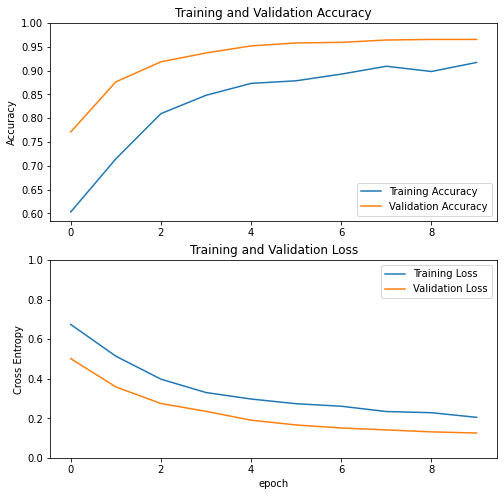

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [33]:
len(model.trainable_variables)

58

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 4:07 - loss: 0.2749 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1:20 - loss: 0.2172 - accuracy: 0.9705

 5/63 [=>............................] - ETA: 47s - loss: 0.1981 - accuracy: 0.9654 

 7/63 [==>...........................] - ETA: 33s - loss: 0.1853 - accuracy: 0.9637

 9/63 [===>..........................] - ETA: 25s - loss: 0.1758 - accuracy: 0.9636

11/63 [====>.........................] - ETA: 20s - loss: 0.1682 - accuracy: 0.9643

13/63 [=====>........................] - ETA: 16s - loss: 0.1646 - accuracy: 0.9638

15/63 [======>.......................] - ETA: 14s - loss: 0.1618 - accuracy: 0.9632

17/63 [=======>......................] - ETA: 12s - loss: 0.1591 - accuracy: 0.9626

19/63 [========>.....................] - ETA: 10s - loss: 0.1565 - accuracy: 0.9621

21/63 [=========>....................] - ETA: 9s - loss: 0.1544 - accuracy: 0.9616 

23/63 [=========>....................] - ETA: 8s - loss: 0.1528 - accuracy: 0.9609

25/63 [==========>...................] - ETA: 7s - loss: 0.1516 - accuracy: 0.9600

27/63 [===========>..................] - ETA: 6s - loss: 0.1506 - accuracy: 0.9593

29/63 [============>.................] - ETA: 5s - loss: 0.1503 - accuracy: 0.9584

31/63 [=============>................] - ETA: 5s - loss: 0.1502 - accuracy: 0.9575

33/63 [==============>...............] - ETA: 4s - loss: 0.1502 - accuracy: 0.9566

35/63 [===============>..............] - ETA: 4s - loss: 0.1500 - accuracy: 0.9560

37/63 [================>.............] - ETA: 3s - loss: 0.1498 - accuracy: 0.9554

39/63 [=================>............] - ETA: 3s - loss: 0.1498 - accuracy: 0.9547

41/63 [==================>...........] - ETA: 2s - loss: 0.1498 - accuracy: 0.9541

43/63 [===================>..........] - ETA: 2s - loss: 0.1497 - accuracy: 0.9534

45/63 [====================>.........] - ETA: 2s - loss: 0.1498 - accuracy: 0.9527

47/63 [=====================>........] - ETA: 1s - loss: 0.1498 - accuracy: 0.9521

49/63 [======================>.......] - ETA: 1s - loss: 0.1497 - accuracy: 0.9515

51/63 [=======================>......] - ETA: 1s - loss: 0.1496 - accuracy: 0.9510

53/63 [========================>.....] - ETA: 1s - loss: 0.1495 - accuracy: 0.9506

55/63 [=========================>....] - ETA: 0s - loss: 0.1494 - accuracy: 0.9502

58/63 [==========================>...] - ETA: 0s - loss: 0.1493 - accuracy: 0.9496

61/63 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.9490

63/63 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.9487

63/63 [==============================] - 8s 122ms/step - loss: 0.1497 - accuracy: 0.9485 - val_loss: 0.0611 - val_accuracy: 0.9752


Epoch 11/20


 1/63 [..............................] - ETA: 19s - loss: 0.0772 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 7s - loss: 0.0915 - accuracy: 0.9462 

 5/63 [=>............................] - ETA: 5s - loss: 0.1034 - accuracy: 0.9471

 7/63 [==>...........................] - ETA: 4s - loss: 0.1142 - accuracy: 0.9464

 9/63 [===>..........................] - ETA: 3s - loss: 0.1180 - accuracy: 0.9481

11/63 [====>.........................] - ETA: 3s - loss: 0.1185 - accuracy: 0.9497

13/63 [=====>........................] - ETA: 2s - loss: 0.1185 - accuracy: 0.9507

15/63 [======>.......................] - ETA: 2s - loss: 0.1180 - accuracy: 0.9514

17/63 [=======>......................] - ETA: 2s - loss: 0.1174 - accuracy: 0.9518

19/63 [========>.....................] - ETA: 2s - loss: 0.1161 - accuracy: 0.9526

21/63 [=========>....................] - ETA: 1s - loss: 0.1150 - accuracy: 0.9533

23/63 [=========>....................] - ETA: 1s - loss: 0.1143 - accuracy: 0.9537

25/63 [==========>...................] - ETA: 1s - loss: 0.1146 - accuracy: 0.9536

27/63 [===========>..................] - ETA: 1s - loss: 0.1149 - accuracy: 0.9535

29/63 [============>.................] - ETA: 1s - loss: 0.1150 - accuracy: 0.9534

31/63 [=============>................] - ETA: 1s - loss: 0.1152 - accuracy: 0.9533

33/63 [==============>...............] - ETA: 1s - loss: 0.1153 - accuracy: 0.9533

35/63 [===============>..............] - ETA: 1s - loss: 0.1152 - accuracy: 0.9533

37/63 [================>.............] - ETA: 1s - loss: 0.1150 - accuracy: 0.9534

39/63 [=================>............] - ETA: 0s - loss: 0.1149 - accuracy: 0.9535

41/63 [==================>...........] - ETA: 0s - loss: 0.1148 - accuracy: 0.9535

43/63 [===================>..........] - ETA: 0s - loss: 0.1148 - accuracy: 0.9535

45/63 [====================>.........] - ETA: 0s - loss: 0.1148 - accuracy: 0.9534

47/63 [=====================>........] - ETA: 0s - loss: 0.1148 - accuracy: 0.9533

49/63 [======================>.......] - ETA: 0s - loss: 0.1149 - accuracy: 0.9532

51/63 [=======================>......] - ETA: 0s - loss: 0.1150 - accuracy: 0.9531

53/63 [========================>.....] - ETA: 0s - loss: 0.1153 - accuracy: 0.9529

55/63 [=========================>....] - ETA: 0s - loss: 0.1156 - accuracy: 0.9527

58/63 [==========================>...] - ETA: 0s - loss: 0.1164 - accuracy: 0.9524

61/63 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9521

63/63 [==============================] - 3s 54ms/step - loss: 0.1177 - accuracy: 0.9518 - val_loss: 0.0575 - val_accuracy: 0.9851


Epoch 12/20


 1/63 [..............................] - ETA: 19s - loss: 0.0268 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 0.0456 - accuracy: 0.9965 

 5/63 [=>............................] - ETA: 5s - loss: 0.0639 - accuracy: 0.9882

 7/63 [==>...........................] - ETA: 4s - loss: 0.0704 - accuracy: 0.9848

 9/63 [===>..........................] - ETA: 3s - loss: 0.0734 - accuracy: 0.9833

11/63 [====>.........................] - ETA: 3s - loss: 0.0764 - accuracy: 0.9817

13/63 [=====>........................] - ETA: 2s - loss: 0.0777 - accuracy: 0.9807

15/63 [======>.......................] - ETA: 2s - loss: 0.0782 - accuracy: 0.9801

17/63 [=======>......................] - ETA: 2s - loss: 0.0781 - accuracy: 0.9799

19/63 [========>.....................] - ETA: 2s - loss: 0.0781 - accuracy: 0.9793

21/63 [=========>....................] - ETA: 1s - loss: 0.0777 - accuracy: 0.9790

23/63 [=========>....................] - ETA: 1s - loss: 0.0773 - accuracy: 0.9787

25/63 [==========>...................] - ETA: 1s - loss: 0.0767 - accuracy: 0.9786

27/63 [===========>..................] - ETA: 1s - loss: 0.0765 - accuracy: 0.9784

29/63 [============>.................] - ETA: 1s - loss: 0.0766 - accuracy: 0.9780

31/63 [=============>................] - ETA: 1s - loss: 0.0768 - accuracy: 0.9775

33/63 [==============>...............] - ETA: 1s - loss: 0.0770 - accuracy: 0.9772

35/63 [===============>..............] - ETA: 1s - loss: 0.0774 - accuracy: 0.9767

37/63 [================>.............] - ETA: 1s - loss: 0.0779 - accuracy: 0.9763

39/63 [=================>............] - ETA: 0s - loss: 0.0785 - accuracy: 0.9758

41/63 [==================>...........] - ETA: 0s - loss: 0.0793 - accuracy: 0.9753

43/63 [===================>..........] - ETA: 0s - loss: 0.0800 - accuracy: 0.9748

45/63 [====================>.........] - ETA: 0s - loss: 0.0806 - accuracy: 0.9744

47/63 [=====================>........] - ETA: 0s - loss: 0.0813 - accuracy: 0.9740

49/63 [======================>.......] - ETA: 0s - loss: 0.0819 - accuracy: 0.9736

51/63 [=======================>......] - ETA: 0s - loss: 0.0825 - accuracy: 0.9732

53/63 [========================>.....] - ETA: 0s - loss: 0.0831 - accuracy: 0.9728

55/63 [=========================>....] - ETA: 0s - loss: 0.0836 - accuracy: 0.9725

58/63 [==========================>...] - ETA: 0s - loss: 0.0843 - accuracy: 0.9721

61/63 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9716

63/63 [==============================] - 3s 54ms/step - loss: 0.0856 - accuracy: 0.9712 - val_loss: 0.0459 - val_accuracy: 0.9851


Epoch 13/20


 1/63 [..............................] - ETA: 19s - loss: 0.0563 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 7s - loss: 0.0724 - accuracy: 0.9653 

 5/63 [=>............................] - ETA: 5s - loss: 0.0763 - accuracy: 0.9610

 7/63 [==>...........................] - ETA: 4s - loss: 0.0906 - accuracy: 0.9542

 9/63 [===>..........................] - ETA: 3s - loss: 0.0956 - accuracy: 0.9525

11/63 [====>.........................] - ETA: 3s - loss: 0.0968 - accuracy: 0.9528

13/63 [=====>........................] - ETA: 2s - loss: 0.0999 - accuracy: 0.9523

15/63 [======>.......................] - ETA: 2s - loss: 0.1013 - accuracy: 0.9524

17/63 [=======>......................] - ETA: 2s - loss: 0.1023 - accuracy: 0.9525

19/63 [========>.....................] - ETA: 2s - loss: 0.1025 - accuracy: 0.9528

21/63 [=========>....................] - ETA: 1s - loss: 0.1030 - accuracy: 0.9529

23/63 [=========>....................] - ETA: 1s - loss: 0.1032 - accuracy: 0.9532

25/63 [==========>...................] - ETA: 1s - loss: 0.1030 - accuracy: 0.9535

27/63 [===========>..................] - ETA: 1s - loss: 0.1028 - accuracy: 0.9538

29/63 [============>.................] - ETA: 1s - loss: 0.1027 - accuracy: 0.9541

31/63 [=============>................] - ETA: 1s - loss: 0.1027 - accuracy: 0.9543

33/63 [==============>...............] - ETA: 1s - loss: 0.1027 - accuracy: 0.9543

35/63 [===============>..............] - ETA: 1s - loss: 0.1025 - accuracy: 0.9544

37/63 [================>.............] - ETA: 1s - loss: 0.1023 - accuracy: 0.9546

39/63 [=================>............] - ETA: 0s - loss: 0.1023 - accuracy: 0.9547

41/63 [==================>...........] - ETA: 0s - loss: 0.1023 - accuracy: 0.9548

43/63 [===================>..........] - ETA: 0s - loss: 0.1024 - accuracy: 0.9548

45/63 [====================>.........] - ETA: 0s - loss: 0.1025 - accuracy: 0.9549

47/63 [=====================>........] - ETA: 0s - loss: 0.1027 - accuracy: 0.9549

49/63 [======================>.......] - ETA: 0s - loss: 0.1029 - accuracy: 0.9549

51/63 [=======================>......] - ETA: 0s - loss: 0.1030 - accuracy: 0.9549

53/63 [========================>.....] - ETA: 0s - loss: 0.1033 - accuracy: 0.9548

55/63 [=========================>....] - ETA: 0s - loss: 0.1036 - accuracy: 0.9548

58/63 [==========================>...] - ETA: 0s - loss: 0.1039 - accuracy: 0.9547

61/63 [============================>.] - ETA: 0s - loss: 0.1040 - accuracy: 0.9548

63/63 [==============================] - 3s 54ms/step - loss: 0.1041 - accuracy: 0.9549 - val_loss: 0.0383 - val_accuracy: 0.9851


Epoch 14/20


 1/63 [..............................] - ETA: 19s - loss: 0.0339 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 0.0776 - accuracy: 0.9670 

 5/63 [=>............................] - ETA: 5s - loss: 0.0774 - accuracy: 0.9661

 7/63 [==>...........................] - ETA: 4s - loss: 0.0738 - accuracy: 0.9689

 9/63 [===>..........................] - ETA: 3s - loss: 0.0696 - accuracy: 0.9709

11/63 [====>.........................] - ETA: 3s - loss: 0.0688 - accuracy: 0.9716

13/63 [=====>........................] - ETA: 2s - loss: 0.0688 - accuracy: 0.9717

15/63 [======>.......................] - ETA: 2s - loss: 0.0689 - accuracy: 0.9715

17/63 [=======>......................] - ETA: 2s - loss: 0.0684 - accuracy: 0.9717

19/63 [========>.....................] - ETA: 2s - loss: 0.0679 - accuracy: 0.9720

21/63 [=========>....................] - ETA: 1s - loss: 0.0675 - accuracy: 0.9721

23/63 [=========>....................] - ETA: 1s - loss: 0.0672 - accuracy: 0.9721

25/63 [==========>...................] - ETA: 1s - loss: 0.0670 - accuracy: 0.9722

27/63 [===========>..................] - ETA: 1s - loss: 0.0670 - accuracy: 0.9723

29/63 [============>.................] - ETA: 1s - loss: 0.0672 - accuracy: 0.9723

31/63 [=============>................] - ETA: 1s - loss: 0.0674 - accuracy: 0.9722

33/63 [==============>...............] - ETA: 1s - loss: 0.0675 - accuracy: 0.9721

35/63 [===============>..............] - ETA: 1s - loss: 0.0676 - accuracy: 0.9721

37/63 [================>.............] - ETA: 1s - loss: 0.0678 - accuracy: 0.9720

39/63 [=================>............] - ETA: 0s - loss: 0.0682 - accuracy: 0.9718

41/63 [==================>...........] - ETA: 0s - loss: 0.0686 - accuracy: 0.9717

43/63 [===================>..........] - ETA: 0s - loss: 0.0691 - accuracy: 0.9715

45/63 [====================>.........] - ETA: 0s - loss: 0.0696 - accuracy: 0.9714

47/63 [=====================>........] - ETA: 0s - loss: 0.0700 - accuracy: 0.9713

49/63 [======================>.......] - ETA: 0s - loss: 0.0704 - accuracy: 0.9712

51/63 [=======================>......] - ETA: 0s - loss: 0.0708 - accuracy: 0.9711

53/63 [========================>.....] - ETA: 0s - loss: 0.0714 - accuracy: 0.9709

55/63 [=========================>....] - ETA: 0s - loss: 0.0720 - accuracy: 0.9707

58/63 [==========================>...] - ETA: 0s - loss: 0.0729 - accuracy: 0.9704

61/63 [============================>.] - ETA: 0s - loss: 0.0736 - accuracy: 0.9701

63/63 [==============================] - 3s 54ms/step - loss: 0.0743 - accuracy: 0.9699 - val_loss: 0.0380 - val_accuracy: 0.9864


Epoch 15/20


 1/63 [..............................] - ETA: 19s - loss: 0.0696 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 7s - loss: 0.0646 - accuracy: 0.9774 

 5/63 [=>............................] - ETA: 5s - loss: 0.0664 - accuracy: 0.9780

 7/63 [==>...........................] - ETA: 4s - loss: 0.0685 - accuracy: 0.9760

 9/63 [===>..........................] - ETA: 3s - loss: 0.0678 - accuracy: 0.9760

11/63 [====>.........................] - ETA: 3s - loss: 0.0664 - accuracy: 0.9763

13/63 [=====>........................] - ETA: 2s - loss: 0.0651 - accuracy: 0.9765

15/63 [======>.......................] - ETA: 2s - loss: 0.0647 - accuracy: 0.9768

17/63 [=======>......................] - ETA: 2s - loss: 0.0646 - accuracy: 0.9769

19/63 [========>.....................] - ETA: 2s - loss: 0.0657 - accuracy: 0.9768

21/63 [=========>....................] - ETA: 1s - loss: 0.0666 - accuracy: 0.9766

23/63 [=========>....................] - ETA: 1s - loss: 0.0678 - accuracy: 0.9761

25/63 [==========>...................] - ETA: 1s - loss: 0.0687 - accuracy: 0.9757

27/63 [===========>..................] - ETA: 1s - loss: 0.0692 - accuracy: 0.9754

29/63 [============>.................] - ETA: 1s - loss: 0.0696 - accuracy: 0.9752

31/63 [=============>................] - ETA: 1s - loss: 0.0699 - accuracy: 0.9750

33/63 [==============>...............] - ETA: 1s - loss: 0.0701 - accuracy: 0.9749

35/63 [===============>..............] - ETA: 1s - loss: 0.0707 - accuracy: 0.9746

37/63 [================>.............] - ETA: 1s - loss: 0.0711 - accuracy: 0.9744

39/63 [=================>............] - ETA: 0s - loss: 0.0716 - accuracy: 0.9742

41/63 [==================>...........] - ETA: 0s - loss: 0.0723 - accuracy: 0.9739

43/63 [===================>..........] - ETA: 0s - loss: 0.0730 - accuracy: 0.9736

45/63 [====================>.........] - ETA: 0s - loss: 0.0737 - accuracy: 0.9732

47/63 [=====================>........] - ETA: 0s - loss: 0.0743 - accuracy: 0.9729

49/63 [======================>.......] - ETA: 0s - loss: 0.0749 - accuracy: 0.9727

51/63 [=======================>......] - ETA: 0s - loss: 0.0754 - accuracy: 0.9724

53/63 [========================>.....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9722

55/63 [=========================>....] - ETA: 0s - loss: 0.0764 - accuracy: 0.9719

58/63 [==========================>...] - ETA: 0s - loss: 0.0771 - accuracy: 0.9716

61/63 [============================>.] - ETA: 0s - loss: 0.0779 - accuracy: 0.9712

63/63 [==============================] - 3s 53ms/step - loss: 0.0785 - accuracy: 0.9708 - val_loss: 0.0429 - val_accuracy: 0.9814


Epoch 16/20


 1/63 [..............................] - ETA: 19s - loss: 0.0886 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 7s - loss: 0.0635 - accuracy: 0.9618 

 5/63 [=>............................] - ETA: 5s - loss: 0.0539 - accuracy: 0.9715

 7/63 [==>...........................] - ETA: 4s - loss: 0.0477 - accuracy: 0.9768

 9/63 [===>..........................] - ETA: 3s - loss: 0.0440 - accuracy: 0.9800

11/63 [====>.........................] - ETA: 3s - loss: 0.0430 - accuracy: 0.9814

13/63 [=====>........................] - ETA: 2s - loss: 0.0427 - accuracy: 0.9820

15/63 [======>.......................] - ETA: 2s - loss: 0.0436 - accuracy: 0.9822

17/63 [=======>......................] - ETA: 2s - loss: 0.0450 - accuracy: 0.9821

19/63 [========>.....................] - ETA: 2s - loss: 0.0458 - accuracy: 0.9821

21/63 [=========>....................] - ETA: 1s - loss: 0.0465 - accuracy: 0.9821

23/63 [=========>....................] - ETA: 1s - loss: 0.0468 - accuracy: 0.9822

25/63 [==========>...................] - ETA: 1s - loss: 0.0470 - accuracy: 0.9822

27/63 [===========>..................] - ETA: 1s - loss: 0.0474 - accuracy: 0.9821

29/63 [============>.................] - ETA: 1s - loss: 0.0478 - accuracy: 0.9821

31/63 [=============>................] - ETA: 1s - loss: 0.0484 - accuracy: 0.9819

33/63 [==============>...............] - ETA: 1s - loss: 0.0491 - accuracy: 0.9817

35/63 [===============>..............] - ETA: 1s - loss: 0.0497 - accuracy: 0.9814

37/63 [================>.............] - ETA: 1s - loss: 0.0503 - accuracy: 0.9812

39/63 [=================>............] - ETA: 0s - loss: 0.0507 - accuracy: 0.9810

41/63 [==================>...........] - ETA: 0s - loss: 0.0514 - accuracy: 0.9807

43/63 [===================>..........] - ETA: 0s - loss: 0.0520 - accuracy: 0.9803

45/63 [====================>.........] - ETA: 0s - loss: 0.0526 - accuracy: 0.9800

47/63 [=====================>........] - ETA: 0s - loss: 0.0533 - accuracy: 0.9797

49/63 [======================>.......] - ETA: 0s - loss: 0.0539 - accuracy: 0.9794

51/63 [=======================>......] - ETA: 0s - loss: 0.0545 - accuracy: 0.9791

53/63 [========================>.....] - ETA: 0s - loss: 0.0550 - accuracy: 0.9788

55/63 [=========================>....] - ETA: 0s - loss: 0.0555 - accuracy: 0.9786

58/63 [==========================>...] - ETA: 0s - loss: 0.0563 - accuracy: 0.9782

61/63 [============================>.] - ETA: 0s - loss: 0.0570 - accuracy: 0.9777

63/63 [==============================] - 3s 54ms/step - loss: 0.0578 - accuracy: 0.9774 - val_loss: 0.0354 - val_accuracy: 0.9839


Epoch 17/20


 1/63 [..............................] - ETA: 19s - loss: 0.0075 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 0.0433 - accuracy: 0.9757 

 5/63 [=>............................] - ETA: 5s - loss: 0.0481 - accuracy: 0.9729

 7/63 [==>...........................] - ETA: 4s - loss: 0.0499 - accuracy: 0.9737

 9/63 [===>..........................] - ETA: 3s - loss: 0.0497 - accuracy: 0.9755

11/63 [====>.........................] - ETA: 3s - loss: 0.0496 - accuracy: 0.9767

13/63 [=====>........................] - ETA: 2s - loss: 0.0498 - accuracy: 0.9774

15/63 [======>.......................] - ETA: 2s - loss: 0.0503 - accuracy: 0.9778

17/63 [=======>......................] - ETA: 2s - loss: 0.0509 - accuracy: 0.9780

19/63 [========>.....................] - ETA: 2s - loss: 0.0517 - accuracy: 0.9780

21/63 [=========>....................] - ETA: 1s - loss: 0.0520 - accuracy: 0.9782

23/63 [=========>....................] - ETA: 1s - loss: 0.0527 - accuracy: 0.9783

25/63 [==========>...................] - ETA: 1s - loss: 0.0533 - accuracy: 0.9783

27/63 [===========>..................] - ETA: 1s - loss: 0.0537 - accuracy: 0.9784

29/63 [============>.................] - ETA: 1s - loss: 0.0542 - accuracy: 0.9784

31/63 [=============>................] - ETA: 1s - loss: 0.0549 - accuracy: 0.9782

33/63 [==============>...............] - ETA: 1s - loss: 0.0557 - accuracy: 0.9779

35/63 [===============>..............] - ETA: 1s - loss: 0.0565 - accuracy: 0.9777

37/63 [================>.............] - ETA: 1s - loss: 0.0571 - accuracy: 0.9775

39/63 [=================>............] - ETA: 0s - loss: 0.0578 - accuracy: 0.9773

41/63 [==================>...........] - ETA: 0s - loss: 0.0584 - accuracy: 0.9770

43/63 [===================>..........] - ETA: 0s - loss: 0.0591 - accuracy: 0.9767

45/63 [====================>.........] - ETA: 0s - loss: 0.0598 - accuracy: 0.9764

47/63 [=====================>........] - ETA: 0s - loss: 0.0603 - accuracy: 0.9761

49/63 [======================>.......] - ETA: 0s - loss: 0.0608 - accuracy: 0.9759

51/63 [=======================>......] - ETA: 0s - loss: 0.0613 - accuracy: 0.9756

53/63 [========================>.....] - ETA: 0s - loss: 0.0616 - accuracy: 0.9755

55/63 [=========================>....] - ETA: 0s - loss: 0.0620 - accuracy: 0.9753

58/63 [==========================>...] - ETA: 0s - loss: 0.0625 - accuracy: 0.9751

61/63 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9748

63/63 [==============================] - 3s 54ms/step - loss: 0.0634 - accuracy: 0.9746 - val_loss: 0.0441 - val_accuracy: 0.9864


Epoch 18/20


 1/63 [..............................] - ETA: 19s - loss: 0.0376 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 0.0421 - accuracy: 0.9965 

 5/63 [=>............................] - ETA: 5s - loss: 0.0492 - accuracy: 0.9923

 7/63 [==>...........................] - ETA: 4s - loss: 0.0491 - accuracy: 0.9917

 9/63 [===>..........................] - ETA: 3s - loss: 0.0479 - accuracy: 0.9919

11/63 [====>.........................] - ETA: 3s - loss: 0.0462 - accuracy: 0.9923

13/63 [=====>........................] - ETA: 2s - loss: 0.0444 - accuracy: 0.9927

15/63 [======>.......................] - ETA: 2s - loss: 0.0443 - accuracy: 0.9927

17/63 [=======>......................] - ETA: 2s - loss: 0.0443 - accuracy: 0.9927

19/63 [========>.....................] - ETA: 2s - loss: 0.0457 - accuracy: 0.9919

21/63 [=========>....................] - ETA: 1s - loss: 0.0471 - accuracy: 0.9911

23/63 [=========>....................] - ETA: 1s - loss: 0.0482 - accuracy: 0.9904

25/63 [==========>...................] - ETA: 1s - loss: 0.0490 - accuracy: 0.9899

27/63 [===========>..................] - ETA: 1s - loss: 0.0496 - accuracy: 0.9893

29/63 [============>.................] - ETA: 1s - loss: 0.0503 - accuracy: 0.9888

31/63 [=============>................] - ETA: 1s - loss: 0.0511 - accuracy: 0.9883

33/63 [==============>...............] - ETA: 1s - loss: 0.0517 - accuracy: 0.9879

35/63 [===============>..............] - ETA: 1s - loss: 0.0521 - accuracy: 0.9875

37/63 [================>.............] - ETA: 1s - loss: 0.0526 - accuracy: 0.9871

39/63 [=================>............] - ETA: 0s - loss: 0.0529 - accuracy: 0.9868

41/63 [==================>...........] - ETA: 0s - loss: 0.0531 - accuracy: 0.9865

43/63 [===================>..........] - ETA: 0s - loss: 0.0534 - accuracy: 0.9861

45/63 [====================>.........] - ETA: 0s - loss: 0.0538 - accuracy: 0.9858

47/63 [=====================>........] - ETA: 0s - loss: 0.0541 - accuracy: 0.9854

49/63 [======================>.......] - ETA: 0s - loss: 0.0544 - accuracy: 0.9850

51/63 [=======================>......] - ETA: 0s - loss: 0.0546 - accuracy: 0.9847

53/63 [========================>.....] - ETA: 0s - loss: 0.0549 - accuracy: 0.9844

55/63 [=========================>....] - ETA: 0s - loss: 0.0551 - accuracy: 0.9841

58/63 [==========================>...] - ETA: 0s - loss: 0.0553 - accuracy: 0.9837

61/63 [============================>.] - ETA: 0s - loss: 0.0556 - accuracy: 0.9834

63/63 [==============================] - 3s 54ms/step - loss: 0.0561 - accuracy: 0.9830 - val_loss: 0.0343 - val_accuracy: 0.9876


Epoch 19/20


 1/63 [..............................] - ETA: 19s - loss: 0.0235 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 0.0484 - accuracy: 0.9792 

 5/63 [=>............................] - ETA: 5s - loss: 0.0528 - accuracy: 0.9791

 7/63 [==>...........................] - ETA: 4s - loss: 0.0524 - accuracy: 0.9789

 9/63 [===>..........................] - ETA: 3s - loss: 0.0514 - accuracy: 0.9787

11/63 [====>.........................] - ETA: 3s - loss: 0.0505 - accuracy: 0.9790

13/63 [=====>........................] - ETA: 2s - loss: 0.0497 - accuracy: 0.9796

15/63 [======>.......................] - ETA: 2s - loss: 0.0487 - accuracy: 0.9801

17/63 [=======>......................] - ETA: 2s - loss: 0.0490 - accuracy: 0.9803

19/63 [========>.....................] - ETA: 2s - loss: 0.0491 - accuracy: 0.9806

21/63 [=========>....................] - ETA: 1s - loss: 0.0491 - accuracy: 0.9807

23/63 [=========>....................] - ETA: 1s - loss: 0.0494 - accuracy: 0.9808

25/63 [==========>...................] - ETA: 1s - loss: 0.0498 - accuracy: 0.9807

27/63 [===========>..................] - ETA: 1s - loss: 0.0505 - accuracy: 0.9805

29/63 [============>.................] - ETA: 1s - loss: 0.0513 - accuracy: 0.9804

31/63 [=============>................] - ETA: 1s - loss: 0.0520 - accuracy: 0.9802

33/63 [==============>...............] - ETA: 1s - loss: 0.0528 - accuracy: 0.9800

35/63 [===============>..............] - ETA: 1s - loss: 0.0535 - accuracy: 0.9797

37/63 [================>.............] - ETA: 1s - loss: 0.0540 - accuracy: 0.9795

39/63 [=================>............] - ETA: 0s - loss: 0.0546 - accuracy: 0.9792

41/63 [==================>...........] - ETA: 0s - loss: 0.0550 - accuracy: 0.9789

43/63 [===================>..........] - ETA: 0s - loss: 0.0554 - accuracy: 0.9787

45/63 [====================>.........] - ETA: 0s - loss: 0.0557 - accuracy: 0.9785

47/63 [=====================>........] - ETA: 0s - loss: 0.0561 - accuracy: 0.9783

49/63 [======================>.......] - ETA: 0s - loss: 0.0567 - accuracy: 0.9781

51/63 [=======================>......] - ETA: 0s - loss: 0.0572 - accuracy: 0.9779

53/63 [========================>.....] - ETA: 0s - loss: 0.0577 - accuracy: 0.9777

55/63 [=========================>....] - ETA: 0s - loss: 0.0583 - accuracy: 0.9775

58/63 [==========================>...] - ETA: 0s - loss: 0.0591 - accuracy: 0.9772

61/63 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9769

63/63 [==============================] - 3s 54ms/step - loss: 0.0608 - accuracy: 0.9766 - val_loss: 0.0375 - val_accuracy: 0.9864


Epoch 20/20


 1/63 [..............................] - ETA: 19s - loss: 0.0031 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 0.0270 - accuracy: 0.9878 

 5/63 [=>............................] - ETA: 5s - loss: 0.0432 - accuracy: 0.9774

 7/63 [==>...........................] - ETA: 4s - loss: 0.0481 - accuracy: 0.9756

 9/63 [===>..........................] - ETA: 3s - loss: 0.0513 - accuracy: 0.9744

11/63 [====>.........................] - ETA: 3s - loss: 0.0528 - accuracy: 0.9742

13/63 [=====>........................] - ETA: 2s - loss: 0.0538 - accuracy: 0.9743

15/63 [======>.......................] - ETA: 2s - loss: 0.0539 - accuracy: 0.9749

17/63 [=======>......................] - ETA: 2s - loss: 0.0539 - accuracy: 0.9751

19/63 [========>.....................] - ETA: 2s - loss: 0.0538 - accuracy: 0.9753

21/63 [=========>....................] - ETA: 1s - loss: 0.0540 - accuracy: 0.9750

23/63 [=========>....................] - ETA: 1s - loss: 0.0541 - accuracy: 0.9750

25/63 [==========>...................] - ETA: 1s - loss: 0.0541 - accuracy: 0.9752

27/63 [===========>..................] - ETA: 1s - loss: 0.0540 - accuracy: 0.9753

29/63 [============>.................] - ETA: 1s - loss: 0.0539 - accuracy: 0.9754

31/63 [=============>................] - ETA: 1s - loss: 0.0538 - accuracy: 0.9755

33/63 [==============>...............] - ETA: 1s - loss: 0.0535 - accuracy: 0.9757

35/63 [===============>..............] - ETA: 1s - loss: 0.0533 - accuracy: 0.9760

37/63 [================>.............] - ETA: 1s - loss: 0.0532 - accuracy: 0.9762

39/63 [=================>............] - ETA: 0s - loss: 0.0533 - accuracy: 0.9763

41/63 [==================>...........] - ETA: 0s - loss: 0.0535 - accuracy: 0.9763

43/63 [===================>..........] - ETA: 0s - loss: 0.0539 - accuracy: 0.9762

45/63 [====================>.........] - ETA: 0s - loss: 0.0542 - accuracy: 0.9762

47/63 [=====================>........] - ETA: 0s - loss: 0.0545 - accuracy: 0.9762

49/63 [======================>.......] - ETA: 0s - loss: 0.0547 - accuracy: 0.9762

51/63 [=======================>......] - ETA: 0s - loss: 0.0548 - accuracy: 0.9762

53/63 [========================>.....] - ETA: 0s - loss: 0.0549 - accuracy: 0.9762

55/63 [=========================>....] - ETA: 0s - loss: 0.0551 - accuracy: 0.9762

58/63 [==========================>...] - ETA: 0s - loss: 0.0553 - accuracy: 0.9762

61/63 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9761

63/63 [==============================] - 3s 54ms/step - loss: 0.0560 - accuracy: 0.9760 - val_loss: 0.0376 - val_accuracy: 0.9876


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

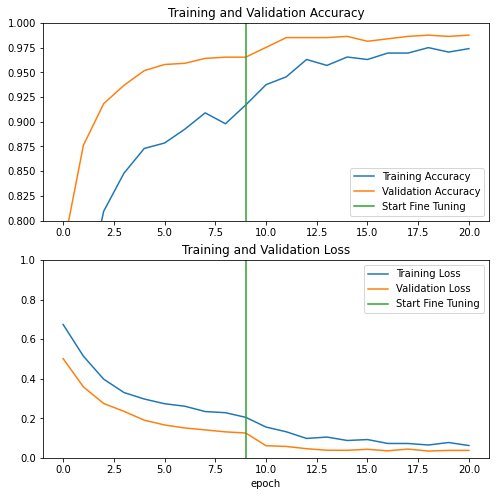

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

3/6 [==============>...............] - ETA: 0s - loss: 0.0223 - accuracy: 0.9792

5/6 [========================>.....] - ETA: 0s - loss: 0.0381 - accuracy: 0.9812

6/6 [==============================] - 1s 84ms/step - loss: 0.0452 - accuracy: 0.9792


Test accuracy : 0.9791666865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0]
Labels:
 [1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0]


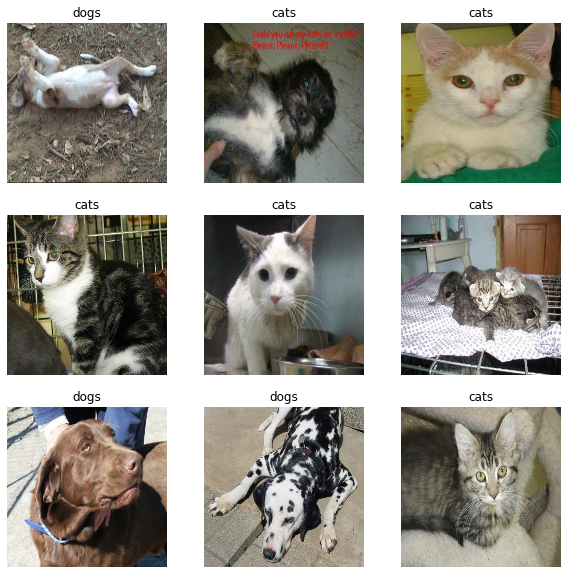

In [38]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
